# Zero-Noise Extrapolation: the N=2 case

Authors: Kyle Godbey, Alexandra Semposki

Maintainer: Alexandra Semposki

Here we'll try developing some error mitigation for the $N=2$ deuteron case from the VQE chapter. Let's begin by importing <tt>pennylane</tt>, <tt>mitiq</tt>, and any other packages we may need, and copy over the code from the $N=2$ notebook for calculating the ground state energy.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from pennylane import numpy as np
import pennylane as qml
import warnings
warnings.filterwarnings('ignore')

import mitiq as mq
from mitiq.zne.scaling import fold_global
from mitiq.zne.inference import RichardsonFactory
from pennylane.transforms import mitigate_with_zne
from qiskit.providers.aer import AerSimulator
import qiskit.providers.aer.noise as noise

plt.style.use(['science','notebook'])

## VQE for N=2 (with noisy simulator)

Here we'll pull from some of the VQE notebook to define the Hamiltonian and circuit again. If you would like to revisit the VQE process, go to [this page](https://kylegodbey.github.io/nuclear-quantum-computing/vqe/n2.html). 

Next, we define a simulator that has a noise model imbedded into it, so that we are simulating running on a real quantum device. Let's see how the convergence of the VQE routine goes.

In [2]:
#define the Hamiltonian we're using again, for N=2
coeffs = [5.906709, 0.218291, -6.125, -2.143304, -2.143304]
obs = [qml.Identity(0), qml.PauliZ(0), qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1), qml.PauliY(0) @ qml.PauliY(1)]

H = qml.Hamiltonian(coeffs, obs)

print(H)

  (-6.125) [Z1]
+ (0.218291) [Z0]
+ (5.906709) [I0]
+ (-2.143304) [X0 X1]
+ (-2.143304) [Y0 Y1]


In [3]:
#define some noise model to use in pennylane from qiskit.test.mock
from qiskit.test.mock import FakeLima
from qiskit.providers.aer.noise import NoiseModel

backend = FakeLima()
noise_model = NoiseModel.from_backend(backend)

#set up noisy device
dev_sim = qml.device("qiskit.aer", wires=2, noise_model=noise_model, optimization_level=0, shots=10000)

#now we'll define the circuit we want to use with this Hamiltonian
def circuit(params, wires):
    t0 = params[0]
    qml.PauliX(wires=0)
    qml.RY(t0, wires=1)
    qml.CNOT(wires=[1,0])
   # return qml.expval(H)

#define cost function
cost_fn = qml.ExpvalCost(circuit, H, dev_sim)

#set up the Qnode to run the above circuit on the simulator (is this necessary?)
sim_qnode = qml.QNode(circuit, dev_sim)

Now we define some initial parameter and convergence info, as before.

In [4]:
#parameter array
init_params = np.array([2.5,])

#convergence information and step size
max_iterations = 80
conv_tol = 1e-06
step_size = 0.01

Let's run VQE as in the VQE chapter. We should get a result that takes longer to converge due to the noise we have added into the device.

In [5]:
#VQE step
opt = qml.GradientDescentOptimizer(stepsize=step_size)

params = init_params

gd_param_history = [params]
gd_cost_history = []

for n in range(max_iterations):

    # Take a step in parameter space and record your energy
    params, prev_energy = opt.step_and_cost(cost_fn, params)

    # This keeps track of our energy for plotting at comparisons
    gd_param_history.append(params)
    gd_cost_history.append(prev_energy)

    # Here we see what the energy of our system is with the new parameters
    energy = cost_fn(params)

    # Calculate difference between new and old energies
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print(
            "Iteration = {:},  Energy = {:.8f} MeV,  Convergence parameter = {"
            ":.8f} MeV".format(n, energy, conv)
        )

    if conv <= conv_tol:
        break

print()
print("Final value of the energy = {:.8f} MeV".format(energy))
print("Number of iterations = ", n)

Iteration = 0,  Energy = 7.84977776 MeV,  Convergence parameter = 0.43411675 MeV
Iteration = 20,  Energy = -0.04717536 MeV,  Convergence parameter = 0.13790896 MeV
Iteration = 40,  Energy = -1.28578824 MeV,  Convergence parameter = 0.01283113 MeV
Iteration = 60,  Energy = -1.35220863 MeV,  Convergence parameter = 0.04286391 MeV

Final value of the energy = -1.37330145 MeV
Number of iterations =  79


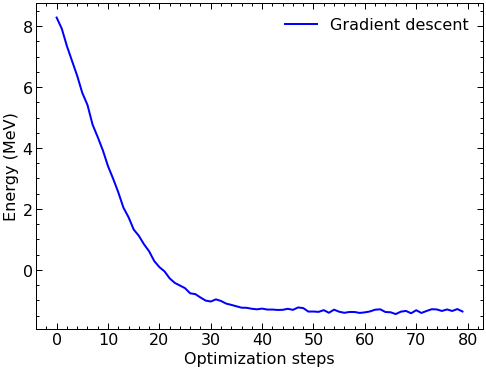

In [6]:
plt.plot(gd_cost_history, "b", label="Gradient descent")

plt.ylabel("Energy (MeV)")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()

The noise here is quite evident in the plot above from the VQE routine results. Let's see if we can implement ZNE to take care of this as we iterate! We'll copy the cells above into the ones below so we can keep the results from above with the noisy simulator for comparison to the results after ZNE is used.

## ZNE for N=2

In [23]:
#set up the extrapolation step and scale factors to use
extrapolate = RichardsonFactory.extrapolate
scale_factors = [1, 2, 3, 4]

def circuit(params, wires):
    t0 = params[0]
    qml.PauliX(wires=0)
    qml.RY(t0, wires=1)
    qml.CNOT(wires=[1,0])
    return qml.expval(H)

sim_qnode = qml.QNode(circuit, dev_sim)

#use ZNE to mitigate error
mitigated_qnode = mitigate_with_zne(scale_factors, fold_global, extrapolate)(sim_qnode)
zne_result = mitigated_qnode(params,wires=2, shots=2**14)

#print the result of the ground state energy
print('N=2 ground state energy result with ZNE: {} MeV'.format(zne_result))

N=2 ground state energy result with ZNE: -1.7711602082519509 MeV


This result is pretty close to the expected -1.75 MeV value for the N=2 ground state of the deuteron! However, it is clear from the above cell that the ZNE method was only applied on the circuit expectation value result and not the result from the VQE run. The latter is much more complicated to implement, and will be left as an exercise for the reader. See if you can nest ZNE into the VQE code above to apply ZNE at each step of the VQE routine! This should greatly improve our results from the VQE iterations.

We'll mention it in the hardware section as well, but some VQE implementations in various quantum computing libraries will include options for error mitigation baked-in, which makes getting up and running a lot easier than building our own.